In [67]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import panel as pn

pn.extension('plotly')

In [68]:
dates = {'Week1':['Resources/sp500_mom_short.csv',
                              '2020-03-02',
                              '2020-03-07'
                             ],
         'Week2':['Resources/sp500_mom_short_wk2.csv',
                            '2020-03-09',
                             '2020-03-14'
                            ]}

In [69]:
def LSTM_predictor(week):
    # Load the stock prices
    SP500_full = pd.read_csv(dates[week][0], index_col='date',infer_datetime_format=True, parse_dates=True)
    SP500_full.reset_index(inplace=True)
    SP500_full['date']=SP500_full['date'].dt.date
    SP500_full.index = pd.to_datetime(SP500_full['date'])
    SP500_full.drop(columns=['date'],inplace=True)
    
    #Trim the Dataframe to the relevant dates.
    df=SP500_full.loc[:dates[week][1]]
    
###############################################################################################  

    # This function accepts the column number for the features (X) and the target (y):
    # It chunks the data up with a rolling window of Xt-n to predict Xt
    # It returns a numpy array of X any y
    def window_data(df, window, feature_col_number, target_col_number):
        X = []
        y = []
        for i in range(len(df) - window):
            features = df.iloc[i:(i + window), feature_col_number]
            target = df.iloc[(i + window), target_col_number]
            X.append(features)
            y.append(target)
        return np.array(X), np.array(y).reshape(-1, 1)
   
    # Predict Closing Prices using a 10 day window of previous closing prices
    # Try a window size anywhere from 1 to 10 and see how the model performance changes
    #jjp - need to add a for loop 

    # Creating the features (X) and target (y) data using the window_data() function.
    window_size = 2

    # Column index 1 is the `Close` column
    feature_column = 7 
    target_column = 7
    X, y = window_data(df, window_size, feature_column, target_column)    
    
################################################################################################ 

    # Use 70% of the data for training and the remaineder for testing
    split = int(0.7 *len(X))
    X_train_rnn = X[: split -1]
    X_test = X[split:]
    y_train_rnn = y[: split -1]
    y_test = y[split:]

    X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_rnn, y_train_rnn)
    
################################################################################################ 

    # Use MinMaxScaler to scale the data between 0 and 1. 

    scaler = MinMaxScaler()
    scaler.fit(X)
    X_train_rnn =scaler.transform(X_train_rnn)
    X_val_rnn =scaler.transform(X_val_rnn)
    X_test = scaler.transform(X_test)
    scaler.fit(y)
    y_train_rnn = scaler.transform(y_train_rnn)
    y_val_rnn = scaler.transform(y_val_rnn)
    y_test =scaler.transform(y_test)

################################################################################################ 

    # Reshape the features for the model
    X_train_rnn = X_train_rnn.reshape((X_train_rnn.shape[0], X_train_rnn.shape[1], 1))
    X_val_rnn = X_val_rnn.reshape((X_val_rnn.shape[0], X_val_rnn.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
################################################################################################ 

    # BUILDING AND TRAINING THE LSTM RNN

    # Build the LSTM model. 
    # The return sequences need to be set to True if you are adding additional LSTM layers, but 
    # You don't have to do this for the final layer. 
    model = Sequential()

    number_units = 100
    dropout_fraction = 0.4

    #first layer:
    model.add(LSTM(
        units=number_units,
        return_sequences=True,
        input_shape=(X_train_rnn.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))
    #second layer
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    #third layer
    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    # #fourth layer
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))

    #output layer
    model.add(Dense(1))
    
    #Compile the model
    model.compile(optimizer="adam", loss="mean_squared_error")
    
################################################################################################ 

    # Train the model
    # Use at least 10 epochs
    # Do not shuffle the data
    # Experiement with the batch size, but a smaller batch size is recommended
    batch_size = 60
    epochs = 250
    model.fit(
        X_train_rnn,
        y_train_rnn,
        validation_data=(X_val_rnn, y_val_rnn),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    
################################################################################################

    #OUT OF SAMPLE PREDICTIONS
    seq = df[df.columns[feature_column]][-2:].tolist()
    forecast=[]
    for i in range (5):
        prediction = model.predict([np.array(seq).reshape(1,X_train_rnn.shape[1],1)])
        seq.append(prediction[0][0])
        seq.pop(0)
        forecast.append([prediction[0][0]])

    forecast_scaled=scaler.inverse_transform(forecast)
    fwd_prices=forecast_scaled.ravel()
    
    real_prices=SP500_full[SP500_full.columns[feature_column]][dates[week][1]:dates[week][2]].tolist()
    A=SP500_full.loc[dates[week][1]:dates[week][2]].index
    out_of_sample=pd.DataFrame({'Real_Prices':real_prices,
                          'Look_Fwd_Prices':fwd_prices},
                          index=A)
    
    look_fwd=pd.concat([SP500_full[SP500_full.columns[feature_column]][:dates[week][2]],out_of_sample],axis=1,join='outer')
    look_fwd_2020=look_fwd.iloc[-90:]

    
################################################################################################

    #IN SAMPLE PREDICTIONS
    predicted = model.predict(X_test)
    # Recover the original prices instead of the scaled version
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    #Create a dataframe of real and predicted values
    stock_closing = pd.DataFrame({
        "Real": real_prices.ravel(),
        "Predicted": predicted_prices.ravel()
    })
    
################################################################################################

#     #PLOT THE RESULTS
    
    #IN SAMPLE
    IN_SAMP=plt.figure()
    stock_closing.plot(title='Close price predictions using LSTM RNN on closing price',figsize=(20,10))
    IN_SAMP.savefig('Resources/in-sample-results_'+str(week)+ '.png')
    stock_closing.to_csv('Resources/in-sample-results_'+str(week)+ '.csv')
    
    #OUT OF SAMPLE
    FWD_SMALL=plt.figure()
    out_of_sample.plot(figsize=(20,10), title='Real Price Data vs Look Fwd Prices (5 Days)')
    FWD_SMALL.savefig('Resources/out-samp-small-results_' +str(week)+ '.png')
    out_of_sample.to_csv('Resources/out-samp-small-results_' +str(week)+ '.csv')
    
    FWD = plt.figure()
    look_fwd_2020.plot(figsize=(20,10),title='Look Fwd Prices (5day) Against Actual')
    FWD.savefig('Resources/out-samp-full-results_' +str(week)+ '.png')   
    look_fwd_2020.to_csv('Resources/out-samp-full-results_' +str(week)+ '.csv')
                                      
    return IN_SAMP
    return FWD_SMALL
    return FWD

In [70]:
weeks = list(dates.keys())

Train on 644 samples, validate on 215 samples
Epoch 1/250
644/644 [==============================] - 7s 10ms/sample - loss: 0.3316 - val_loss: 0.2236
Epoch 2/250
644/644 [==============================] - 0s 287us/sample - loss: 0.0999 - val_loss: 0.0456
Epoch 3/250
644/644 [==============================] - ETA: 0s - loss: 0.037 - 0s 286us/sample - loss: 0.0346 - val_loss: 0.0197
Epoch 4/250
644/644 [==============================] - 0s 283us/sample - loss: 0.0229 - val_loss: 0.0099
Epoch 5/250
644/644 [==============================] - 0s 295us/sample - loss: 0.0177 - val_loss: 0.0098
Epoch 6/250
644/644 [==============================] - 0s 289us/sample - loss: 0.0178 - val_loss: 0.0101
Epoch 7/250
644/644 [==============================] - 0s 284us/sample - loss: 0.0162 - val_loss: 0.0096
Epoch 8/250
644/644 [==============================] - 0s 281us/sample - loss: 0.0173 - val_loss: 0.0099
Epoch 9/250
644/644 [==============================] - 0s 286us/sample - loss: 0.0146 - val

<Figure size 432x288 with 0 Axes>

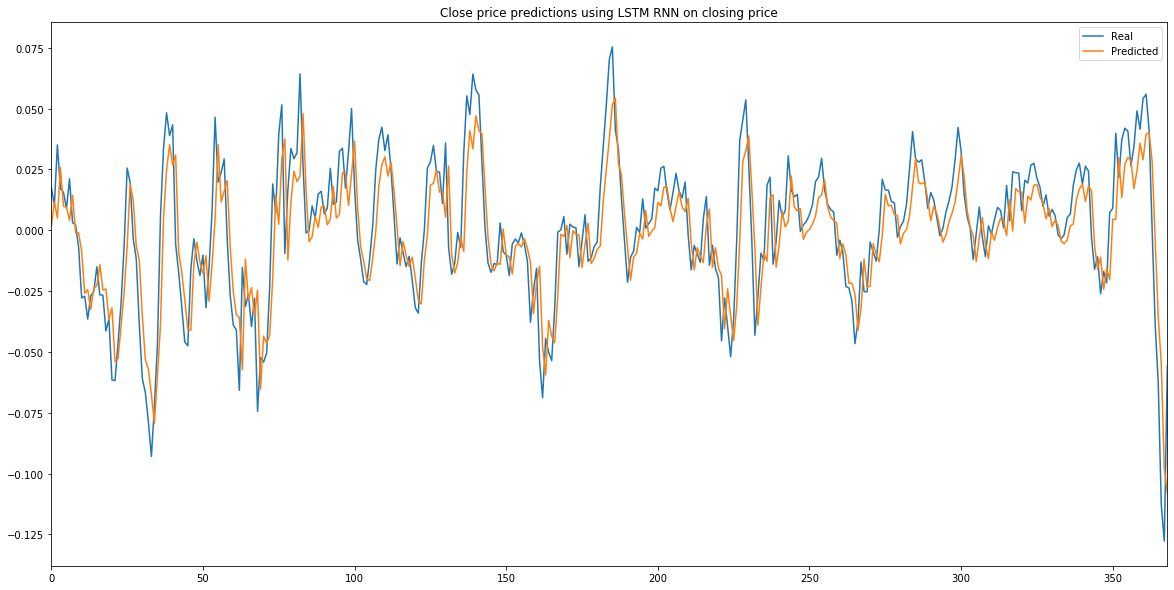

<Figure size 432x288 with 0 Axes>

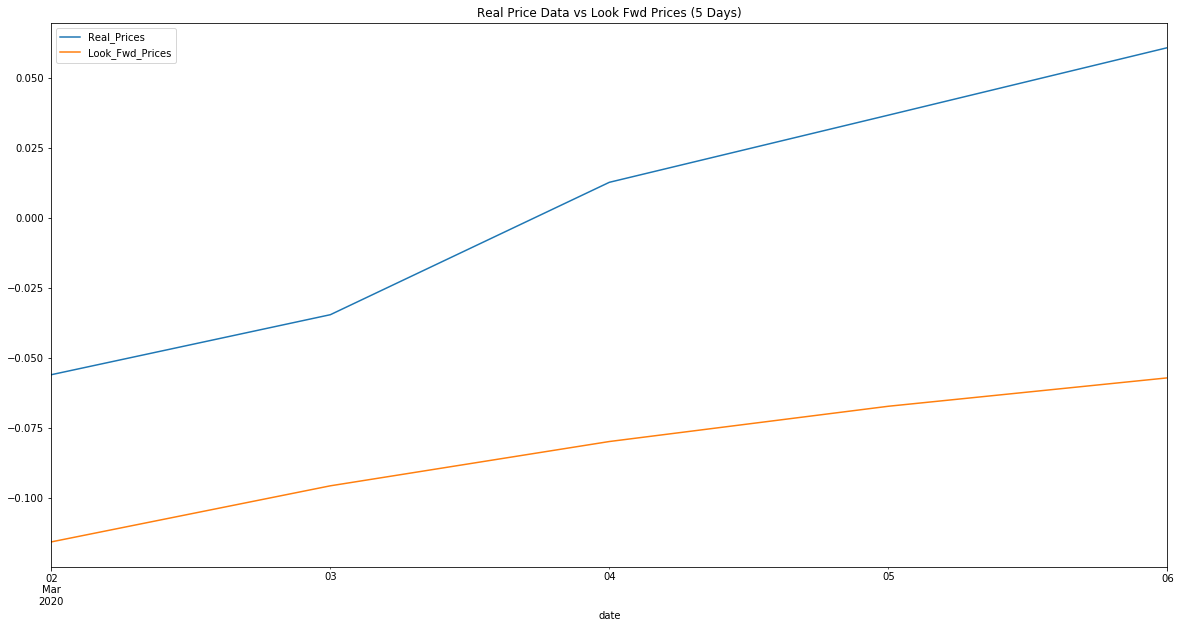

<Figure size 432x288 with 0 Axes>

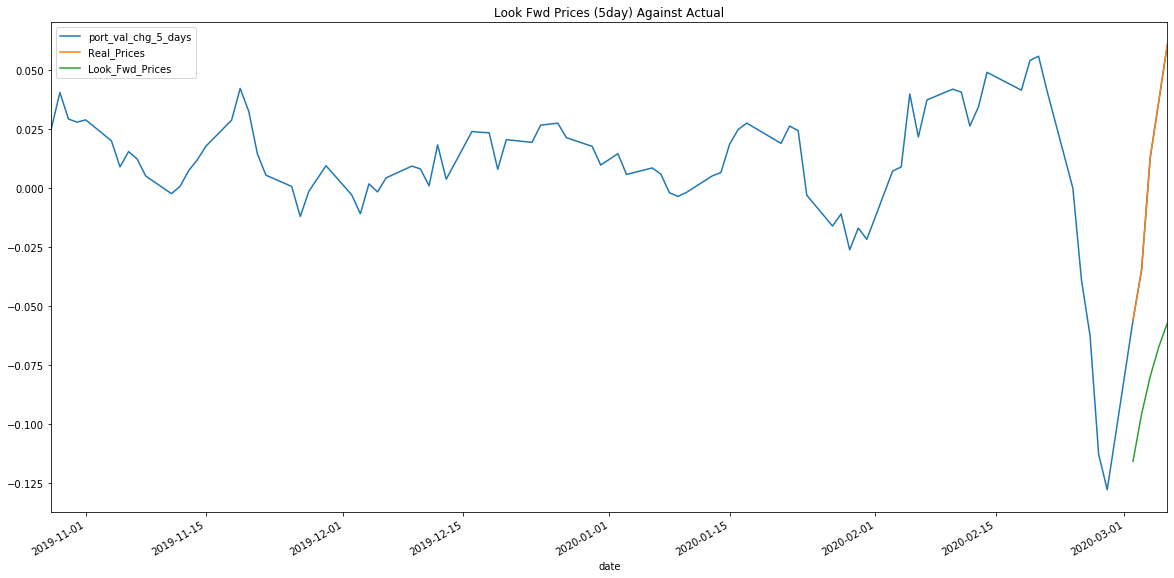

<Figure size 432x288 with 0 Axes>

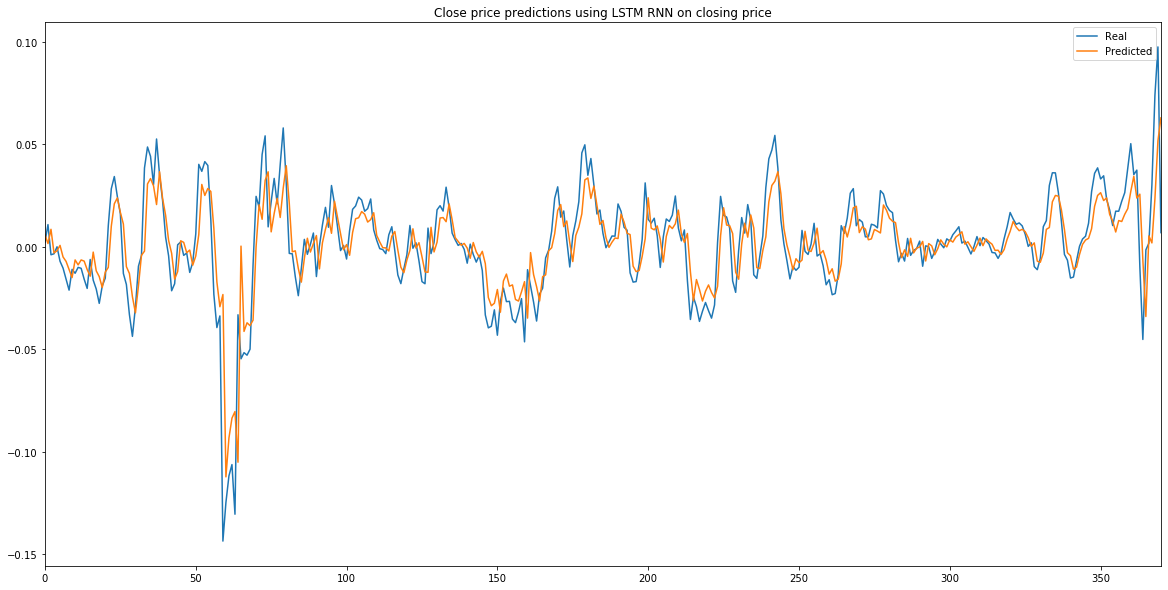

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in weeks:
    LSTM_predictor(i)

---

---

---